In [1]:
import os 
import pandas as pd
import json
from infopath.config import load_training_opt
from infopath.model_loader import load_model_and_optimizer
import torch 
from utils.functions import load_data
import numpy as np
from infopath.train import t_trial_pearson
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {"text.usetex": False, "svg.fonttype": "none"}
mpl.rcParams.update(new_rc_params)
from utils.plot_utils import plot_with_size, strip_right_top_axis
from utils.functions import trial_metric


In [2]:
def t_trial_plot(p_corr_ttrial_model2ms, p_corr_ttrial_model8ms, p_corr_ttrial_lfads, figure_name):
    fig, ax = plot_with_size(47, 22.5)
    violin1 = ax.violinplot([p_corr_ttrial_model2ms], positions=[0], showextrema=False)
    violin2 = ax.violinplot([p_corr_ttrial_model8ms], positions=[1], showextrema=False)
    violin3 = ax.violinplot([p_corr_ttrial_lfads], positions=[2], showextrema=False)
    violin1["bodies"][0].set_facecolor("black")
    violin2["bodies"][0].set_facecolor("black")
    violin3["bodies"][0].set_facecolor("black")
    ax.set_xticks([0,1,2])
    ax.scatter([0,1,2], [p_corr_ttrial_model2ms.mean(), p_corr_ttrial_model8ms.mean(), p_corr_ttrial_lfads.mean()])
    # ax.set_xticklabels(["Train vs Test", "Model vs Test"],)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(0.6,1)
    fig.savefig(f"{figure_name}_t_trial.svg")

In [3]:
path = "../log_dir/4e8975de7db30117ea8fde6d418305e049ddc1eb/"
configs = os.listdir(path)
configs = [config for config in configs if not config.startswith(".DS")]

opts = [load_training_opt(os.path.join(path, config)) for config in configs]
df = pd.DataFrame(
    columns=[
        "delay_dt",
        "syn_delay",
        "tau_mem",
        "t_trial",
        "t_trial_ratio",
        "neuron_loss",
        "config_path",
    ]
)
for i, config in enumerate(configs):
    opt = opts[i]
    results = json.load(open(f"{path+config}/results.json"))
    df.loc[i] = [
        opt.datapath.split("_")[2],
        opt.n_delay,
        opt.tau_list[0],
        max(results["t_trial_pearson"]),
        max(results["t_trial_pearson_ratio"]),
        min(results["neuron_loss"]),
        f"{path+config}",
    ]
df = df[df["tau_mem"] == 10]
df

,delay_dt,syn_delay,tau_mem,t_trial,t_trial_ratio,neuron_loss,config_path
0,delay100,4,10,0.907484,1.012664,7.066952,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
1,delay20,16,10,0.923981,1.028509,63.615528,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
2,delay200,4,10,0.828413,0.941450,7.767801,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
7,delay20,8,10,0.918807,1.021218,21.720742,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
9,delay100,8,10,0.913501,1.016333,26.769146,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
10,delay200,16,10,0.915187,1.015292,34.839992,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
13,delay20,4,10,0.915443,1.017559,7.946482,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
20,delay100,16,10,0.923976,1.027128,50.657800,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
24,delay200,8,10,0.892205,1.000663,15.394245,../log_dir/4e8975de7db30117ea8fde6d418305e049d...
31,delay200,2,10,0.823939,0.943599,8.140217,../log_dir/4e8975de7db30117ea8fde6d418305e049d...


In [9]:
device = "cpu"
lfads20ms = torch.tensor(np.load("lfads_rates_20ms.npy"), device="cpu")[:,100:].permute(1,0,2) * 1.
lfads200ms = torch.tensor(np.load("lfads_rates_200ms.npy"), device="cpu")[:,100:].permute(1,0,2) * 1.
# lfads_spikes = [torch.poisson(lfads20ms), torch.poisson(lfads200ms)]
lfads_spikes = [lfads20ms, lfads200ms]
# lfads_spikes = [lfads20ms, lfads200ms]
pcorr_lfads, pcorr_data = [], []
pcorr_model = []
for i, delay_dt in enumerate(["delay20", "delay200"]):
    pcorr_model.append([])
    # for j in ([2]):
    for j in ([2,4,8,16]):
        opt = load_training_opt(
            f"{df[df['delay_dt']==delay_dt][df['syn_delay']==j]['config_path'].values[0]}"
        )
        opt.device = device
        opt.log_path = "../" + opt.log_path
        model = load_model_and_optimizer(opt,reload=True,last_best="best")[0]
        model.opt.datapath = "../" + model.opt.datapath
        
        (
            train_spikes,
            train_jaw,
            session_info_train,
            test_spikes,
            test_jaw,
            session_info_test,
        ) = load_data(model)
        with torch.no_grad():
            spikes = model(torch.ones(100),seed=1)[0]
        p_corr_ttrial_model = trial_metric(
            model.filter_fun2(model.filter_fun1(test_spikes)),
            model.filter_fun2(model.filter_fun1(spikes)),
            None,
            None,
            session_info_test,
            model,
        )
        pcorr_model[-1].append(p_corr_ttrial_model.mean())

    p_corr_ttrial_lfads = trial_metric(
        model.filter_fun2(model.filter_fun1(test_spikes)),
        model.filter_fun2(model.filter_fun1(lfads_spikes[i])),
        None,
        None,
        session_info_test,
        model,
    )
    pcorr_lfads.append(p_corr_ttrial_lfads.mean())
    p_corr_ttrial_data = trial_metric(
        model.filter_fun2(model.filter_fun1(test_spikes)),
        model.filter_fun2(model.filter_fun1(train_spikes)),
        None,
        None,
        session_info_test,
        model,
    )
    pcorr_data.append(p_corr_ttrial_data.mean())



/tmp/ipykernel_572654/1642357061.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f"{df[df['delay_dt']==delay_dt][df['syn_delay']==j]['config_path'].values[0]}"
/tmp/ipykernel_572654/1642357061.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f"{df[df['delay_dt']==delay_dt][df['syn_delay']==j]['config_path'].values[0]}"
/tmp/ipykernel_572654/1642357061.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f"{df[df['delay_dt']==delay_dt][df['syn_delay']==j]['config_path'].values[0]}"
/tmp/ipykernel_572654/1642357061.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f"{df[df['delay_dt']==delay_dt][df['syn_delay']==j]['config_path'].values[0]}"
/tmp/ipykernel_572654/1642357061.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f"{df[df['delay_dt']==delay_dt][df['syn_delay']==j]['config_path'].values[0]}"
/tmp/ipykernel_

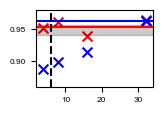

In [29]:
with plt.rc_context({"font.size": 6, "font.family": "arial"}):
    fig, ax = plot_with_size(30)
    syn_delay = df.syn_delay.unique() * 2
    ids = np.argsort(syn_delay)
    syn_delay = syn_delay[ids]
    ax.scatter(
        syn_delay,
        np.array(pcorr_model[0]),
        label="delay_dt=20ms",
        marker="x",
        color="red",
        s=50,
    )

    ax.scatter(
        syn_delay,
        np.array(pcorr_model[-1]),
        label="delay_dt=200ms",
        marker="x",
        color="blue",
        s=50,
    )
    ax.plot([2,35], [pcorr_lfads[0], pcorr_lfads[0]], color="red")
    ax.plot([2,35], [pcorr_lfads[1], pcorr_lfads[1]], color="blue")
    ax.set_xlim(2,34)
    ax.set_ylim(0.86, 0.98)
    ax.fill_between([2,35],[pcorr_data[0],pcorr_data[0]], [pcorr_data[1], pcorr_data[1]], color="black", alpha=0.2)
    plt.axvline(6, linestyle="--", color="black")
    fig.savefig("FigureA5/synaptic_delay.svg")
    plt.show()

In [24]:
syn_delay

array([ 8, 32, 16,  4])

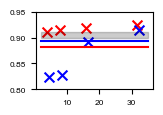

In [33]:
with plt.rc_context({"font.size": 6, "font.family": "arial"}):
    fig, ax = plot_with_size(30)
    df20ms = df[df.delay_dt == "delay20"].sort_values(by=["syn_delay", "tau_mem"])
    df200ms = df[df.delay_dt == "delay200"].sort_values(by=["syn_delay", "tau_mem"])

    t_trial_tau10_dt20 = df20ms[df20ms.tau_mem == 10].t_trial.values
    t_trial_tau10_dt20[t_trial_tau10_dt20 > 1] = 1
    t_trial_tau10_dt200 = df200ms[df200ms.tau_mem == 10].t_trial.values
    t_trial_tau10_dt200[t_trial_tau10_dt200 > 1] = 1

    ax.scatter(
        df20ms.syn_delay.unique() * 2 - 0.3,
        t_trial_tau10_dt20,
        label="delay_dt=20ms",
        marker="x",
        color="red",
        s=50,
    )

    ax.scatter(
        df20ms.syn_delay.unique() * 2 + 0.3,
        t_trial_tau10_dt200,
        label="delay_dt=200ms",
        marker="x",
        color="blue",
        s=50,
    )
    ax.plot([2,35], [pcorr_lfads[0], pcorr_lfads[0]], color="red")
    ax.plot([2,35], [pcorr_lfads[1], pcorr_lfads[1]], color="blue")
    
    ax.set_ylim(0.8, 0.95)
    ax.fill_between([2,35],[pcorr_data[0],pcorr_data[0]], [pcorr_data[1], pcorr_data[1]], color="black", alpha=0.2)

    plt.show()